In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/batches.meta
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/readme.html


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
import numpy as np



### **Dataset Preparation and Transformations**
Before training our model, we need to preprocess the CIFAR-10 dataset to enhance its generalization ability. This involves:  

1. **Data Augmentation (for Training Set)**  

   - **Normalization**: Scales pixel values to have a mean of `(0.4914, 0.4822, 0.4465)` and a standard deviation of `(0.2023, 0.1994, 0.2010)`, based on CIFAR-10 statistics.  

2. **Test Set Processing**  
   - Unlike the training set, test images undergo only **normalization** to ensure consistent input distributions during evaluation.  

3. **Data Loading**  
   - The dataset is loaded using `torchvision.datasets.CIFAR10`, and we define **train and test dataloaders** with a batch size of `128`.  
   - `num_workers=2` allows for parallel data loading, speeding up training.  

4. **Class Labels Extraction**  
   - We dynamically load the **class names** from the dataset's metadata file to ensure correct labeling during visualization.  


In [7]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import os
import pickle
import torchvision

train_transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

batch_size = 128

data_root = '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python'

trainset = torchvision.datasets.CIFAR10(root=data_root, train=True, download=False, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root=data_root, train=False, download=False, transform=test_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Load class labels dynamically
meta_file = os.path.join(data_root, "cifar-10-batches-py", "batches.meta")
with open(meta_file, 'rb') as f:
    meta_data = pickle.load(f, encoding='bytes')

# Extract and decode class labels
classes = [label.decode("utf-8") for label in meta_data[b'label_names']]

print("Classes:", classes)


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


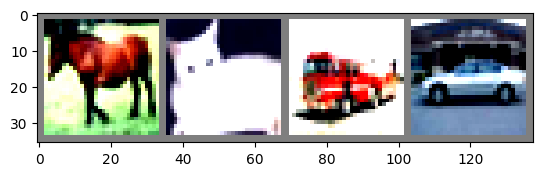

Labels: ['horse', 'cat', 'truck', 'automobile']


In [10]:
# Get a batch of training data
data_iter = iter(trainloader)
images, labels = next(data_iter)  # Use 'next()' instead of 'data_iter.next()'

# Show images
imshow(torchvision.utils.make_grid(images[:4]))  # Display first 4 images
print('Labels:', [classes[labels[j]] for j in range(4)])  # Print the labels of the images


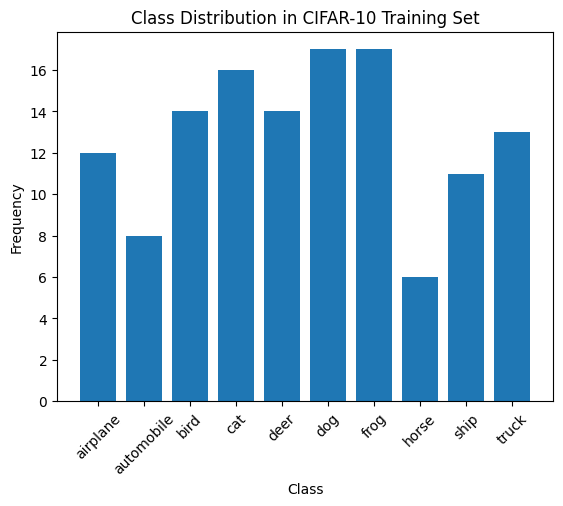

In [11]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the frequency of each class in the training dataset
class_counts = Counter(labels.numpy())

# Plot class distribution
plt.bar(classes, [class_counts[i] for i in range(10)])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in CIFAR-10 Training Set')
plt.xticks(rotation=45)
plt.show()


### **Advanced Training Pipeline for CIFAR-10 using ResNet18**  
This code implements a **deep learning training pipeline** for CIFAR-10 using a modified ResNet18 architecture. The methodology includes **data augmentation, mixup & CutMix regularization, Stochastic Weight Averaging (SWA), gradient accumulation, automatic mixed precision (AMP), and an advanced learning rate scheduler** for better generalization and training efficiency. Below, we break down each key concept in the code.

---

## **1. Model Architecture - Modified ResNet18**  
ResNet18 is a widely used convolutional neural network (CNN) that employs **residual connections**, enabling deeper architectures to be trained without vanishing gradient issues.  

### **Modifications Applied:**
- **First Convolution Layer Change**:  
  - Standard ResNet18 uses a `7x7` kernel with a stride of `2`, followed by max-pooling.  
  - Since CIFAR-10 images are **small (32×32 pixels)**, we replace it with a `3x3` kernel (stride `1`) and remove the max-pooling layer (`nn.Identity()`).  
- **Dropout Regularization (0.3)**:  
  - Helps prevent overfitting by randomly deactivating neurons during training.  
- **Custom Fully Connected (FC) Layer**:  
  - The original ResNet18 is designed for ImageNet (1,000 classes), but here it's modified for CIFAR-10 (**10 classes**).  


## **2. Data Augmentation with Mixup & CutMix**  
Data augmentation artificially increases the diversity of training data, improving generalization.

### **Mixup (Interpolation-based Regularization)**
- Mixup **blends two images and their corresponding labels**.
- Helps prevent the model from memorizing labels and forces it to generalize.
- Implemented as:
  \[
  X' = \lambda X + (1 - \lambda) X_{perm}
  \]
  \[
  Y' = \lambda Y + (1 - \lambda) Y_{perm}
  \]
- Here, \( \lambda \) is sampled from a Beta distribution.

```python
mixed_x = lam * x + (1 - lam) * x[index, :]
y_a, y_b = y, y[index]
```

### **CutMix (Patch-based Regularization)**
- Instead of blending, **CutMix replaces a random region of an image** with another image’s patch.
- The label is adjusted proportionally to the patch size.
- This encourages the model to focus on multiple parts of an image, reducing overfitting.

```python
bbx1, bby1, bbx2, bby2 = cutmix_box(x.size(2), x.size(3), lam)
mixed_x = x.clone()
mixed_x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
```

---

## **3. Training Optimizations**
### **(A) Label Smoothing Cross-Entropy Loss**  
Instead of assigning **100% probability to the correct class**, label smoothing **assigns a small probability to incorrect classes**, making the model less confident and more robust.

```python
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
```

### **(B) Mixed Precision Training (AMP)**
- Uses **16-bit floating point computations** for efficiency.
- Reduces GPU memory usage and speeds up training.
- `GradScaler()` ensures gradients don’t become too small during updates.


---

## **4. Learning Rate Scheduling**
Instead of using a fixed learning rate, we use **Cosine Annealing** and **Stochastic Weight Averaging (SWA)**.

### **(A) Cosine Annealing LR Scheduler**
- Reduces the learning rate **smoothly** from a high value to a small value.
- Helps in better convergence compared to fixed step decay.

```python
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)
```

### **(B) Stochastic Weight Averaging (SWA)**
- Averages multiple models' weights across epochs.
- Produces a smoother loss surface, reducing test error.

```python
swa_model = AveragedModel(model)
swa_scheduler = SWALR(optimizer, anneal_strategy="cos", anneal_epochs=5, swa_lr=0.05)
```

At the end of training, batch norm statistics are recomputed:

```python
torch.optim.swa_utils.update_bn(trainloader, swa_model)
```

---

## **5. Training Loop with Gradient Accumulation**
- **Gradient Accumulation** updates weights **every `N` batches** instead of every batch.
- Effectively increases batch size without increasing memory usage.

```python
scaler.scale(loss / accumulation_steps).backward()

if (batch_idx + 1) % accumulation_steps == 0:
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad()
```



## **🔹 Summary of Key Techniques Used**
| Technique | Purpose |
|-----------|---------|
| **ResNet18 Modifications** | Adapted for CIFAR-10 by modifying convolution and pooling layers. |
| **Mixup & CutMix** | Prevents overfitting by blending/cutting images. |
| **Label Smoothing** | Reduces overconfidence in predictions. |
| **Automatic Mixed Precision (AMP)** | Accelerates training while reducing memory usage. |
| **Gradient Accumulation** | Allows training with effectively larger batch sizes. |
| **Cosine Annealing LR Scheduler** | Dynamically adjusts learning rate for better convergence. |
| **Stochastic Weight Averaging (SWA)** | Stabilizes the final model by averaging weights. |

---

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.amp import GradScaler, autocast  # Updated for future PyTorch versions
import numpy as np
import torch.nn.functional as F
from torchvision.models import resnet18
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.optim.swa_utils import AveragedModel, SWALR

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# ResNet18 Model with modifications
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.model = resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()  # Remove maxpool for small images
        self.model.fc = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.3)  # Increased dropout

    def forward(self, x):
        x = self.model(x)
        return self.dropout(x)

# Initialize model, loss, and optimizer
model = ResNet18().to(device)
swa_model = AveragedModel(model)  # Stochastic Weight Averaging

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # Adaptive label smoothing
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)
swa_scheduler = SWALR(optimizer, anneal_strategy="cos", anneal_epochs=5, swa_lr=0.05)

scaler = GradScaler()

# Mixup and CutMix Augmentations
def mixup_cutmix_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    index = torch.randperm(x.size(0)).to(device)
    if np.random.rand() < 0.5:
        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam
    else:
        bbx1, bby1, bbx2, bby2 = cutmix_box(x.size(2), x.size(3), lam)
        mixed_x = x.clone()
        mixed_x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
        return mixed_x, y, y[index], lam

def cutmix_box(W, H, lam):
    cut_w = int(W * np.sqrt(1 - lam))
    cut_h = int(H * np.sqrt(1 - lam))
    cx, cy = np.random.randint(W), np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

# Training function with gradient accumulation
def train(epoch, accumulation_steps=2):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    optimizer.zero_grad()

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets_a, targets_b, lam = mixup_cutmix_data(inputs, targets)

        with autocast("cuda"):
            outputs = model(inputs)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        
        scaler.scale(loss / accumulation_steps).backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (lam * predicted.eq(targets_a).sum().float() + (1 - lam) * predicted.eq(targets_b).sum().float())

    scheduler.step()
    print(f'Epoch: {epoch}, Loss: {train_loss/len(trainloader):.3f}, Acc: {100.*correct/total:.2f}%')

# Testing function
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100. * correct / total
    print(f'Test Epoch: {epoch}, Loss: {test_loss/len(testloader):.3f}, Acc: {acc:.2f}%')
    return acc

# Training loop with SWA
best_acc = 0
for epoch in range(110):
    train(epoch)
    acc = test(epoch)
    
    if epoch > 10:
        swa_model.update_parameters(model)
        swa_scheduler.step()

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_resnet18.pth')
        print(f'Saved model with accuracy: {best_acc:.2f}%')

# Final SWA Update
torch.optim.swa_utils.update_bn(trainloader, swa_model)
torch.save(swa_model.state_dict(), 'swa_resnet18.pth')
print(f'Final SWA model saved with best accuracy: {best_acc:.2f}%')


In [7]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Requires Grad: {param.requires_grad}")


Layer: model.conv1.weight | Size: torch.Size([64, 3, 3, 3]) | Requires Grad: True
Layer: model.bn1.weight | Size: torch.Size([64]) | Requires Grad: True
Layer: model.bn1.bias | Size: torch.Size([64]) | Requires Grad: True
Layer: model.layer1.0.conv1.weight | Size: torch.Size([64, 64, 3, 3]) | Requires Grad: True
Layer: model.layer1.0.bn1.weight | Size: torch.Size([64]) | Requires Grad: True
Layer: model.layer1.0.bn1.bias | Size: torch.Size([64]) | Requires Grad: True
Layer: model.layer1.0.conv2.weight | Size: torch.Size([64, 64, 3, 3]) | Requires Grad: True
Layer: model.layer1.0.bn2.weight | Size: torch.Size([64]) | Requires Grad: True
Layer: model.layer1.0.bn2.bias | Size: torch.Size([64]) | Requires Grad: True
Layer: model.layer1.1.conv1.weight | Size: torch.Size([64, 64, 3, 3]) | Requires Grad: True
Layer: model.layer1.1.bn1.weight | Size: torch.Size([64]) | Requires Grad: True
Layer: model.layer1.1.bn1.bias | Size: torch.Size([64]) | Requires Grad: True
Layer: model.layer1.1.conv2.

In [16]:
net = model

In [21]:
import pickle
import torch
import numpy as np
import os
import pandas as pd
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader  # Import the missing classes

# -----------------------------------------
# Define the normalization (same as used during training)
# -----------------------------------------
normalize =  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
# -----------------------------------------
# Utility function to load CIFAR batches from pickle files
# -----------------------------------------
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# -----------------------------------------
# Load test data (images and IDs)
# -----------------------------------------
test_batch = load_cifar_batch('/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl')

# Extract images; test data is in (N, W, H, C) format
images_np = test_batch[b'data']  # shape (N, 32, 32, 3)

# Check if IDs are provided in the pickle file; otherwise, use sequential indices.
if b'ids' in test_batch:
    test_ids = test_batch[b'ids']
    # Convert to a numpy array of IDs if needed.
    test_ids = np.array(test_ids)
else:
    test_ids = np.arange(images_np.shape[0])

# Convert images to torch tensor, adjust shape to (N, 3, 32, 32) and normalize.
images_tensor = torch.from_numpy(images_np).permute(0, 3, 1, 2).float() / 255.0
images_tensor = normalize(images_tensor)

# Create a DataLoader for test data
test_dataset = TensorDataset(images_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [16]:
# -----------------------------------------
# Load label names (mapping of class indices to string labels)
# -----------------------------------------
meta_data_dict = load_cifar_batch(os.path.join(
    '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py',
    'batches.meta'))
label_names = meta_data_dict[b'label_names']
label_names = [name.decode('utf-8') for name in label_names]



In [17]:
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
# -----------------------------------------
# Run inference on the test set
# -----------------------------------------
predictions = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Map predicted class indices to their string labels
predicted_labels = [label_names[p] for p in predictions]

# -----------------------------------------
# Create a submission CSV file with columns "ID" and "Labels"
# -----------------------------------------
submission_df = pd.DataFrame({'ID': test_ids, 'Labels': predictions})
submission_df.to_csv('submission-4.csv', index=False)
print("Submission CSV saved as submission.csv")

"With these improvements, our accuracy has climbed from 75% to 82%—a solid leap forward! If only we had implemented them sooner, but hey, better late than never.